In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [2]:
# Trade data

stock_name = 'MRNA.O'

df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

<ipython-input-2-c13263a22201>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date


In [3]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

<ipython-input-3-c687e5b9a9f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date


In [4]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
daily_volatility = []
avg_20day_volatility = []
stocks = []
dates_final = []
auction_log_returns = []
volumes = []

# i = 0
for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min_volume = pd.DataFrame(apple_today['Volume'].resample("10T").sum())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    apple_today_10min = apple_today_10min.join(apple_today_10min_volume)
    apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
#     apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
    volatility_today = apple_today_10min['log_returns'].values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility.append(np.sqrt(39)*np.sqrt(np.mean(np.square(apple_today_10min['log_returns'].values))))
    
    # Total volume for each complete trade day between 930 and 1550
    volumes.append(sum(apple_today_10min[:-1]['Volume']))

volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility})
volatility_df['volatility_ewma20'] = volatility_df['daily_volatility'].ewm(span=20).mean()

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

In [5]:
# Data Processing (10 minute intervals)

dates_qqq = qqq['Date'].unique()
daily_volatility_qqq = []
avg_20day_volatility_qqq = []
stocks_qqq = []
dates_final_qqq = []
auction_log_returns_qqq = []
volumes_qqq = []

# i = 0
for date in dates_qqq:
    
    qqq_today = qqq[qqq['Date'] == date]
    qqq_auction_today = auction_qqq[auction_qqq['Date'] == date]
    
    qqq_today = qqq_today.set_index(pd.DatetimeIndex(qqq_today['Local_Date_Time']))
    qqq_today_10min_max = pd.DataFrame(qqq_today['High'].resample("10T").max())
    qqq_today_10min_min = pd.DataFrame(qqq_today['Low'].resample("10T").min())
    qqq_today_10min_open = pd.DataFrame(qqq_today['Open'].resample("10T").first())
    qqq_today_10min_close = pd.DataFrame(qqq_today['Close'].resample("10T").last())
    qqq_today_10min_volume = pd.DataFrame(qqq_today['Volume'].resample("10T").sum())
    qqq_today_10min = qqq_today_10min_max.join(apple_today_10min_min)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_open)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_close)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_volume)
    qqq_today_10min['log_returns'] = abs(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])) # alternate volatility formula
#     qqq_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(qqq_today_10min['High']/qqq_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])))
    volatility_today_qqq = qqq_today_10min['log_returns'].values
    
    if len(volatility_today_qqq) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final_qqq.append(date)
    
    auction_log_returns_today_qqq = abs(np.log(qqq_auction_today['Price'].iloc[0]/qqq_today_10min['Open'][-1]))
    auction_log_returns_qqq.append(auction_log_returns_today_qqq)
    
    # 10 minute interval volatility * number of complete trade days
    stocks_qqq.append(volatility_today_qqq)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility_qqq.append(np.sqrt(39)*np.sqrt(np.mean(np.square(qqq_today_10min['log_returns'].values))))
    
    # Total volume for each complete trade day between 930 and 1550
    volumes_qqq.append(sum(qqq_today_10min[:-1]['Volume']))

volatility_df_qqq = pd.DataFrame({'Date':dates_final_qqq, 'daily_volatility': daily_volatility_qqq})
volatility_df_qqq['volatility_ewma20'] = volatility_df_qqq['daily_volatility'].ewm(span=20).mean()

stocks_qqq = stocks_qqq[20:]
stocks_qqq = np.vstack(stocks_qqq).T # Training data for Anderson model
avg_20day_volatility_raw_qqq = np.array(volatility_df_qqq['volatility_ewma20'])
avg_20day_volatility_qqq = np.array(volatility_df_qqq['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

In [6]:
class FlexibleFourierRegression():
    '''
    See P.152 Anderson(1997) Appendix B for details
    '''
    
    def __init__(self, N, J=0, P=0, di=[]):
        self.J = J
        self.D = len(di)
        self.P = P
        
        self.N = N
        self.di = di
        self.Id = zeros(shape=(N,))
        self.mu0 = ones(shape=(J+1,))
        self.mu1 = ones(shape=(J+1,))
        self.mu2 = ones(shape=(J+1,))
        self.lamb = ones(shape=(self.D,))
        self.gamma = ones(shape=(P, J+1))
        self.delta = ones(shape=(P, J+1))
        self.p = arange(1, P + 1, 1)
        self.x = concatenate([self.mu0.ravel(), self.mu1.ravel(), self.mu2.ravel(),
            self.lamb.ravel(), self.gamma.ravel(), self.delta.ravel()])    
        
    def train(self, y, sigma_t, tol=0.1):
        """
        Trains model using flexible fourier functional form.
        
        Parameters
        ----------
        y : dependent variable
        
        sigma_t: estimated conditional volatility for day t,
        sigma_t is scalar or vector depending on vector=False/True.
        
        
        
        Returns
        -------
        Regression stats
        """
        assert y.shape[0] == self.N, "input y should have shape[0] == N:"
        n = arange(0, self.N, 1)
        J = self.J
        ## Learning weights for the following parameters
        ## self.mu0, self.mu1, self.mu2, self.lamb, self.gamma, self.delta

        def lsq_fun(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)

            sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
            for j in range(J+1):
                sigma[:,j] = power(sigma[:,j], j)   

            result = (sigma * (quad + dummy + fourier)).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost

        def lsq_fun_vec(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)
            
            component = fourier + quad + dummy
            component = repeat(expand_dims(component, axis=1), len(sigma_t), axis=1)  
            
            sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
            sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
            for j in range(J+1):
                sigma_J[:,:,j] = power(sigma_J[:,:,j], j)   
            
            result = (sigma_J * component).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost
        

        sigma_t = ravel(sigma_t)
        assert sigma_t.shape[0] == y.shape[1], "sigma_t should have shape (t, ) and y should have shape (N, t)"
        res = minimize(lsq_fun_vec, self.x, tol=tol)

        self.mu0 = res.x[0: J+1]
        self.mu1 = res.x[J+1: 2*J+2]
        self.mu2 = res.x[2*J+2: 3*J+3]
        self.lamb = res.x[3*J+3:3*J+3+self.D]
        self.gamma = res.x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
        self.delta = res.x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))            
        
        return res
        
    def predict(self, sigma_t, vector=False):
        
        N = self.N
        D = self.D
        J = self.J
        P = self.P
        p = self.p
        
        gamma = repeat(expand_dims(self.gamma, axis=0), N, axis=0)
        delta = repeat(expand_dims(self.delta, axis=0), N, axis=0)
        n = arange(0, N, 1)
        N1 = (N + 1) / 2
        N2 = (N + 1) * (N + 2) / 6
        
        dummy = self.Id.copy()
        dummy[self.di] = self.lamb
        dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
        
        quad = self.mu0 + outer(n / N1, self.mu1) + outer(square(n) / N2, self.mu2)
        
        cosine = cos(2 * outer(n, self.p) * pi / N)
        sine = sin(2 * outer(n, self.p) * pi / N)
        cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
        sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)
        fourier_expand = gamma * cosine + delta * sine
        fourier = fourier_expand.sum(axis=1)

        sigma_t = ravel(sigma_t)
        component = fourier + quad + dummy
        component = repeat(expand_dims(component, axis=1), sigma_t.shape[0], axis=1)  
        sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
        sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
        for j in range(J+1):
            sigma_J[:,:,j] = power(sigma_J[:,:,j], j)               
        result = (sigma_J * component).sum(axis=-1)
            
        return result

In [7]:
# AAPL stock
stocks2 = stocks.T
stocks2 = stocks2[:200].T
avg_20day_volatility2 = avg_20day_volatility[:200]

In [8]:
fourier = FlexibleFourierRegression(N=39, di=[], J=6, P=20) # 39 10-minute intervals in each trade day
res = fourier.train(stocks, avg_20day_volatility, 0.000001)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.5f}".format(res.fun))

optimizer success: True
objective function (mse): 0.00002


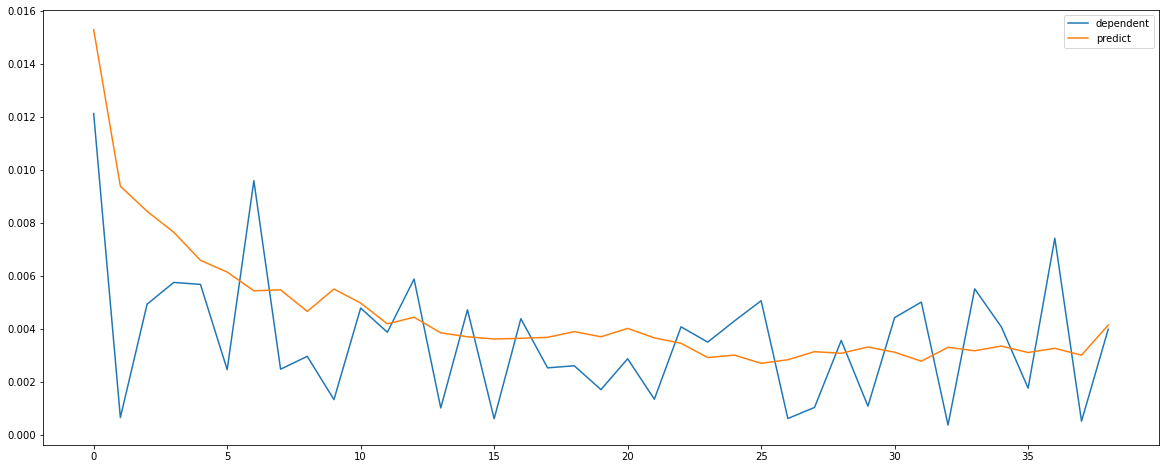

In [9]:
n=230
result = fourier.predict(avg_20day_volatility[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks.T[n], label="dependent")
ax.plot(result, label="predict")
ax.legend()

In [10]:
# QQQ
stocks2_qqq = stocks_qqq.T
stocks2_qqq = stocks2_qqq[:200].T
avg_20day_volatility2_qqq = avg_20day_volatility_qqq[:200]

In [11]:
fourier_qqq = FlexibleFourierRegression(N=39, di=[], J=6, P=20) # 39 10-minute intervals in each trade day
res_qqq = fourier_qqq.train(stocks_qqq, avg_20day_volatility_qqq, 0.000001)
print("optimizer success: {}".format(res_qqq.success))
print("objective function (mse): {:.5f}".format(res_qqq.fun))

optimizer success: True
objective function (mse): 0.00000


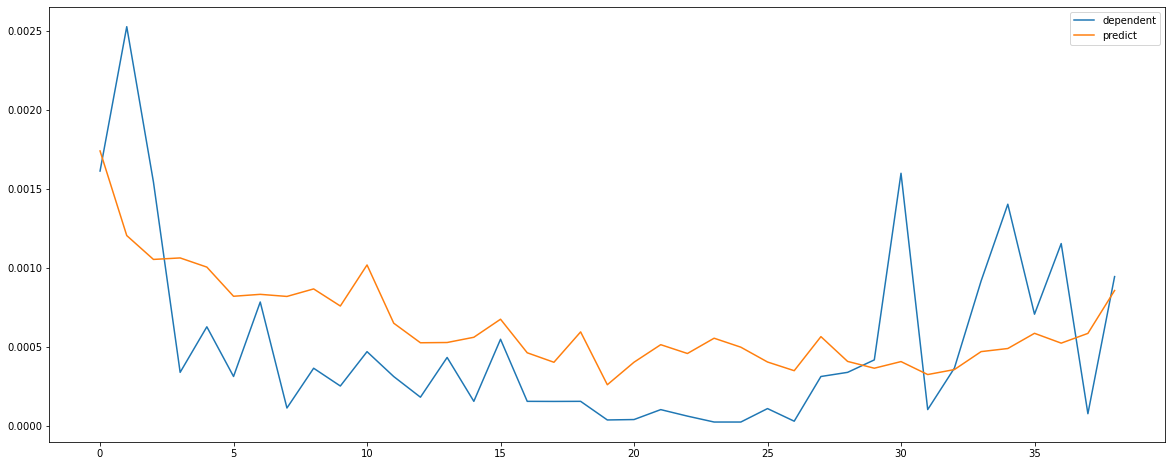

In [12]:
n=230
result_qqq = fourier_qqq.predict(avg_20day_volatility_qqq[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks_qqq.T[n], label="dependent")
ax.plot(result_qqq, label="predict")
ax.legend()

In [13]:
results = [None for i in range(20)]
for vol in avg_20day_volatility:
    result = fourier.predict(vol)
    results.append(result[-1][0])
results = np.array(results)

In [14]:
results_qqq = [None for i in range(20)]
for vol in avg_20day_volatility_qqq:
    result_qqq = fourier_qqq.predict(vol)
    results_qqq.append(result_qqq[-1][0])
results_qqq = np.array(results_qqq)

In [15]:
# Simple linear regression with Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final, 
    'Volume': volumes,
    'Volume_qqq': volumes_qqq,
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Avg20_Volatility_qqq': avg_20day_volatility_raw_qqq, 
    'Anderson': results,
    'Anderson_qqq': results_qqq,
    'Auction_Log_Returns': auction_log_returns
})
final_df = final_df[final_df['Anderson'] > -float('inf')]
final_df

,Date,Volume,Volume_qqq,Avg20_Volatility,Avg20_Volatility_qqq,Anderson,Anderson_qqq,Auction_Log_Returns
20,2020-09-30,11782500,34670209,0.034988,0.015458,0.0036138,0.00272659,0.003668
21,2020-10-01,4980156,29708330,0.033393,0.014755,0.00339443,0.00262848,0.005441
22,2020-10-02,5937806,47305127,0.035947,0.015046,0.00373166,0.00266981,0.008105
23,2020-10-05,4283446,18568359,0.034277,0.014187,0.00351965,0.00254502,0.001530
24,2020-10-06,5484764,33228184,0.034282,0.014234,0.00352035,0.002552,0.004494
...,...,...,...,...,...,...,...,...
246,2021-08-26,5797836,21595483,0.045140,0.005878,0.00431211,0.000902122,0.000599
247,2021-08-27,8769973,18933101,0.043922,0.005928,0.00429284,0.000914363,0.004221
248,2021-08-30,10143300,18151158,0.043391,0.005850,0.00427888,0.000895189,0.002458
249,2021-08-31,6387725,18406465,0.041847,0.005799,0.00421921,0.000882622,0.003271


In [16]:
####################################
# Linear Model with Anderson
####################################

from sklearn.linear_model import LinearRegression
model_volatility = LinearRegression()
model_volatility.fit(final_df[['Volume','Avg20_Volatility','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])

LinearRegression()

In [17]:
####################################
# Confidence Interval with Anderson
####################################

y_pred = model_volatility.predict(final_df[['Volume','Avg20_Volatility','Anderson']][200:])
y_pred_var = pd.DataFrame({'Date': final_df['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.7096774193548387
Within 2 confidence intervals was 0.967741935483871
Within 3 confidence intervals was 1.0


With the Anderson model, it follows the normal distribution closely.

In [18]:
np.mean(merged2['Predicted_Variance']) # narrower than not using Anderson

1.8643063875057462

In [19]:
####################################
# Linear Model with Anderson QQQ
####################################

from sklearn.linear_model import LinearRegression, Ridge
model_volatility_qqq = LinearRegression()
model_volatility_qqq.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])

# model_volatility_qqq = Ridge()
# model_volatility_qqq.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])


LinearRegression()

In [20]:
####################################
# Confidence Interval with QQQ
####################################

y_pred_qqq = model_volatility_qqq.predict(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Anderson']][200:])
y_pred_var_qqq = pd.DataFrame({'Date': final_df['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred_qqq]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var_qqq, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.6129032258064516
Within 2 confidence intervals was 0.9354838709677419
Within 3 confidence intervals was 1.0


With the QQQ model, it follows the normal distribution closely.

In [21]:
np.mean(merged2['Predicted_Variance']) # narrower than not using QQQ

1.7764739589297829

In [22]:
# Simple linear regression without Anderson coefficient
final_df_no_Anderson = pd.DataFrame({
    'Date': dates_final,
    'Volume': volumes,
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Auction_Log_Returns': auction_log_returns
})
final_df_no_Anderson = final_df_no_Anderson[np.isnan(final_df_no_Anderson['Avg20_Volatility']) == False]
final_df_no_Anderson

,Date,Volume,Avg20_Volatility,Auction_Log_Returns
0,2020-09-01,6048072,0.023112,0.002055
1,2020-09-02,7526180,0.029398,0.001392
2,2020-09-03,10990041,0.043384,0.002316
3,2020-09-04,8795556,0.045643,0.001700
4,2020-09-08,13456533,0.047662,0.004247
...,...,...,...,...
246,2021-08-26,5797836,0.045140,0.000599
247,2021-08-27,8769973,0.043922,0.004221
248,2021-08-30,10143300,0.043391,0.002458
249,2021-08-31,6387725,0.041847,0.003271


In [23]:
####################################
# Linear Model without Anderson
####################################

from sklearn.linear_model import LinearRegression
model_no_volatility = LinearRegression()
model_no_volatility.fit(final_df_no_Anderson[['Volume','Avg20_Volatility']][:200], final_df_no_Anderson[['Auction_Log_Returns']][:200])

LinearRegression()

In [24]:
#######################################
# Confidence Interval without Anderson
#######################################

y_pred_no_Anderson = model_no_volatility.predict(final_df_no_Anderson[['Volume','Avg20_Volatility']][200:])
y_pred_var_no_Anderson = pd.DataFrame({'Date': final_df_no_Anderson['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred_no_Anderson]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var_no_Anderson, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.5882352941176471
Within 2 confidence intervals was 0.9215686274509803
Within 3 confidence intervals was 0.9803921568627451


Without the Anderson model, it does not follow the normal distribution as closely.

In [25]:
np.mean(merged2['Predicted_Variance'])

1.3006477210391914

In [26]:
########################################
# Linear Regression Output with Anderson
########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred))

Model Coefficients: [[ 8.43916687e-11  1.85993696e-01 -1.45990737e+00]]
Mean Absolute Error: 0.002213251426395608
Mean Squared Error: 8.229315639573659e-06
Coefficient of Determination: -0.5120352343138708


In [27]:
########################################
# Linear Regression Output with Anderson + QQQ
########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_volatility_qqq.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))

Model Coefficients: [[ 8.66247248e-11  1.74722205e-01  6.36126552e-02 -1.34231950e+00]]
Mean Absolute Error: 0.002120100018390953
Mean Squared Error: 7.56325938817681e-06
Coefficient of Determination: -0.3896556143969918


In [28]:
###########################################
# Linear Regression Output without Anderson
###########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_no_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))
print("Mean Squared Error:", mean_squared_error(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))
print("Coefficient of Determination:", r2_score(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))

Model Coefficients: [[3.90905947e-11 7.86927142e-02]]
Mean Absolute Error: 0.0024193510690941034
Mean Squared Error: 2.082611952514644e-05
Coefficient of Determination: 0.07010012235065244


In [29]:
# Adding QQQ data